In [1]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import KFold,GridSearchCV  , cross_val_score , train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder , label_binarize
from sklearn.externals import joblib
from sklearn.utils import class_weight
from scipy.stats import norm , boxcox, zscore

from sklearn.metrics import *

from catboost import Pool,CatBoostClassifier
import xgboost as xgb


seed = 7
np.random.seed(seed)
from matplotlib import rcParams
rcParams['patch.force_edgecolor'] = True
rcParams['patch.facecolor'] = 'w'

# Loading Data

In [66]:
train=pd.read_csv("Train_v2.csv")
test=pd.read_csv("Test_v2.csv")
variable_definition=pd.read_csv("VariableDefinitions.csv")

In [3]:
train.head()

,country,year,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


change order of columns 

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 11 columns):
country                   23524 non-null object
year                      23524 non-null int64
location_type             23524 non-null object
cellphone_access          23524 non-null object
age_of_respondent         23524 non-null int64
gender_of_respondent      23524 non-null object
relationship_with_head    23524 non-null object
marital_status            23524 non-null object
education_level           23524 non-null object
job_type                  23524 non-null object
bank_account              23524 non-null object
dtypes: int64(2), object(9)
memory usage: 2.0+ MB


In [23]:
test.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10086 entries, 0 to 10085
Data columns (total 11 columns):
country                   10086 non-null object
year                      10086 non-null int64
uniqueid                  10086 non-null object
location_type             10086 non-null object
cellphone_access          10086 non-null object
age_of_respondent         10086 non-null int64
gender_of_respondent      10086 non-null object
relationship_with_head    10086 non-null object
marital_status            10086 non-null object
education_level           10086 non-null object
job_type                  10086 non-null object
dtypes: int64(2), object(9)
memory usage: 866.8+ KB


In [29]:
variable_definition

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


# Data visualisation

 1. **Categorical features**

Text(0.5, 1.0, 'class distribution')

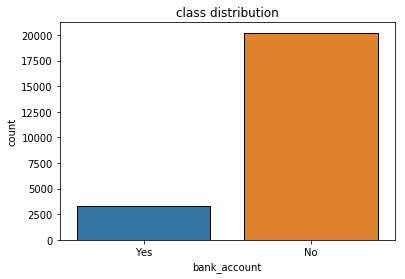

In [6]:
sns.countplot(data=train,x="bank_account")
plt.title("class distribution")

In [7]:
a=round( len(train[train.bank_account=="Yes"])/len(train) *100 ,2)
b=round( len(train[train.bank_account=="No"])/len(train) *100 ,2)
print("the data is umbalanced with ratio of {}/{} ".format(a,b))


the data is umbalanced with ratio of 14.08/85.92 


Text(0.5, 1.0, 'gender distribution')

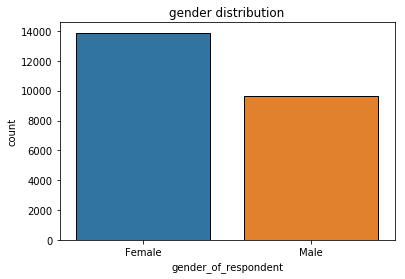

In [8]:
sns.countplot(data=train,x="gender_of_respondent")
plt.title("gender distribution")

Text(0.5, 1.0, 'country distribution')

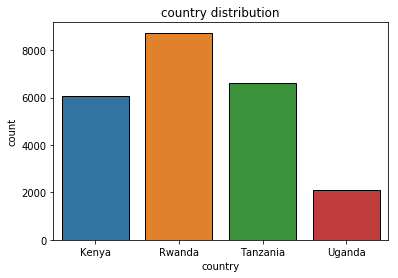

In [9]:
sns.countplot(data=train,x="country")
plt.title("country distribution")

Text(0.5, 1.0, 'cellphone access distribution')

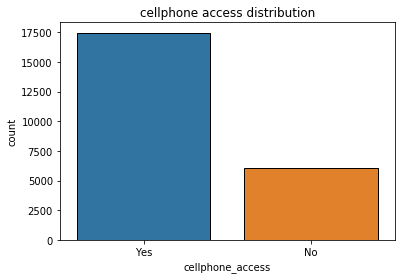

In [10]:
sns.countplot(data=train,x="cellphone_access")
plt.title("cellphone access distribution")

Text(0.5, 1.0, 'location type distribution')

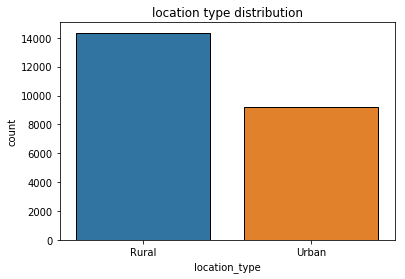

In [12]:
sns.countplot(data=train,x="location_type")
plt.title("location type distribution")

Text(0.5, 1.0, 'relation with head distribution')

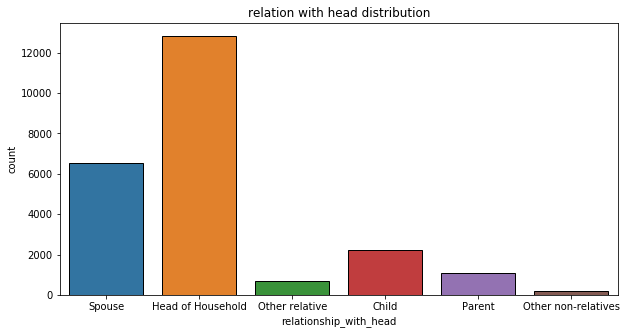

In [11]:
plt.figure(figsize=[10,5])
sns.countplot(data=train,x="relationship_with_head")
plt.title("relation with head distribution")

Text(0.5, 1.0, 'marital status distribution')

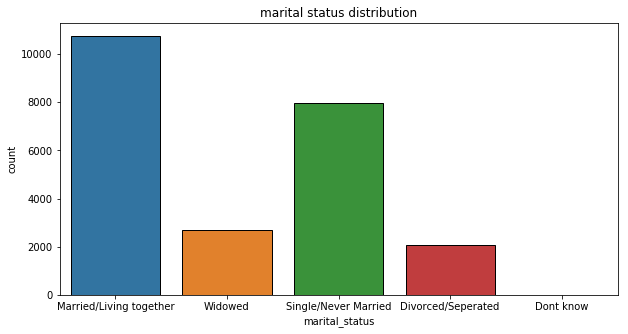

In [14]:
plt.figure(figsize=[10,5])
sns.countplot(data=train,x="marital_status")
plt.title("marital status distribution")

Text(0.5, 1.0, 'education level distribution')

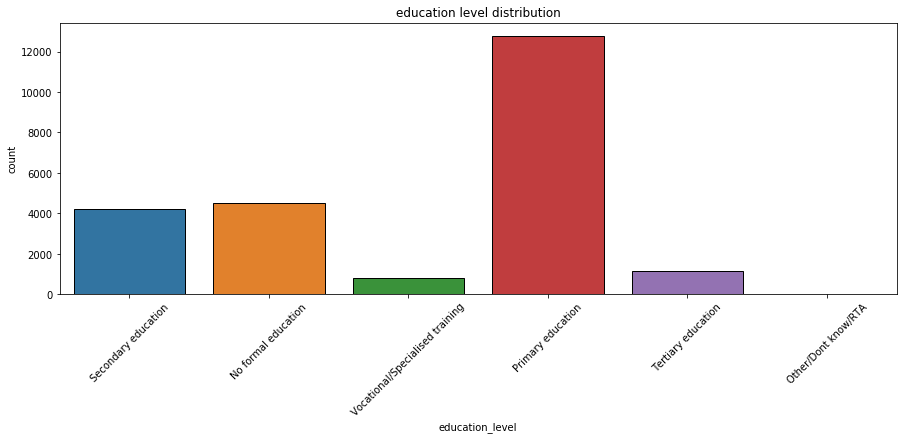

In [12]:
plt.figure(figsize=[15,5])
ax=sns.countplot(data=train,x="education_level")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.title("education level distribution")

Text(0.5, 1.0, 'job type distribution')

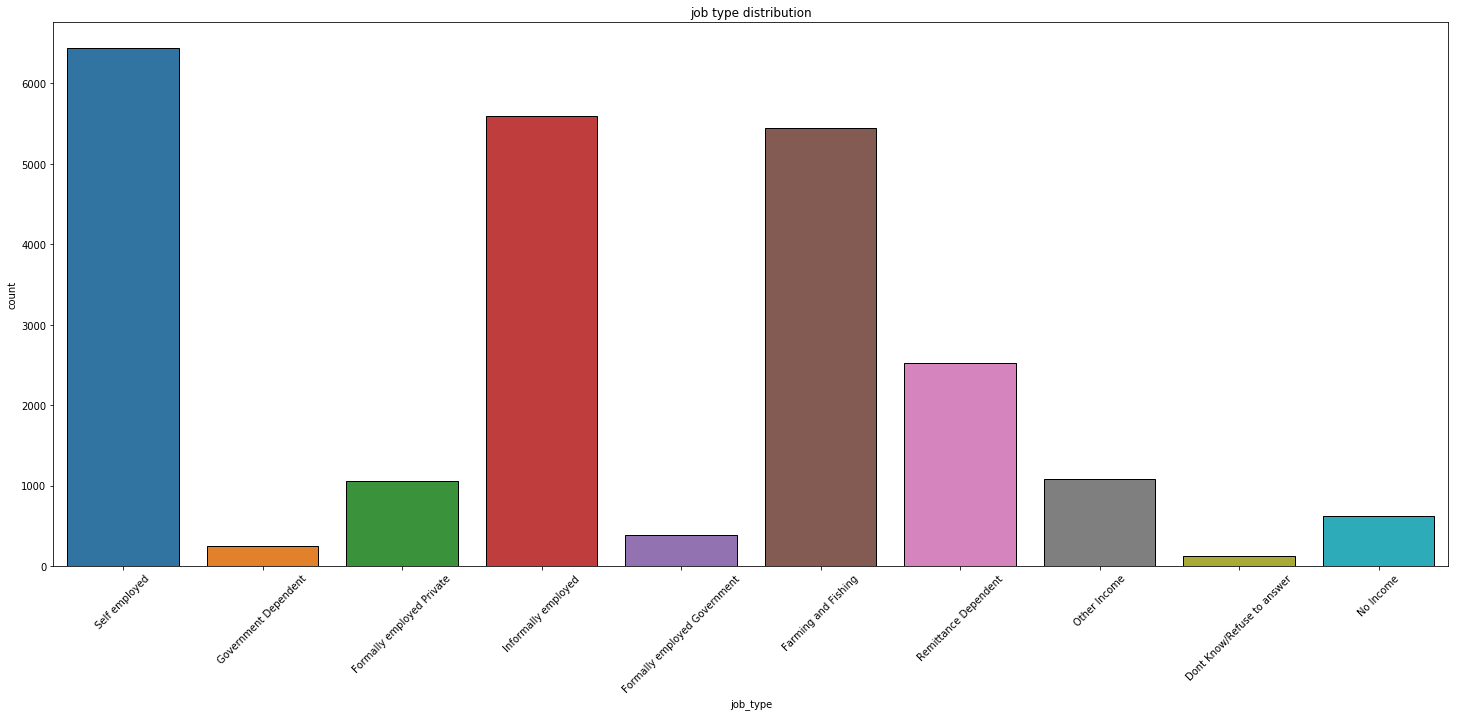

In [16]:
plt.figure(figsize=[25,10])
ax=sns.countplot(data=train,x="job_type")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.title("job type distribution")

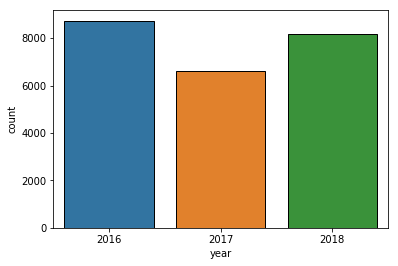

In [23]:
sns.countplot(train.year)

2. **Numerical features** 

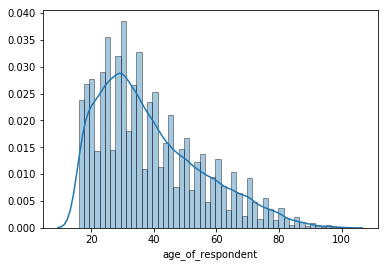

In [19]:
sns.distplot(train.age_of_respondent)

the distribution is clearly right skewed , but since we will use a decision tree based algorithm , hence there is no need to fix it  

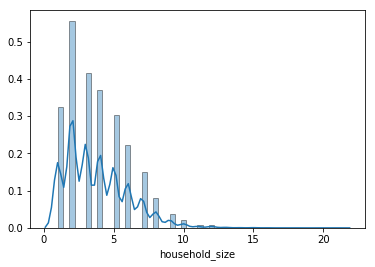

In [20]:
sns.distplot(train.household_size)

# Building the model

1. **data preprocessing**

In [67]:
train.drop(["uniqueid"],axis=1,inplace=True)
#test.drop(["household_size","year"],axis=1,inplace=True)
#"marital_status","gender_of_respondent","year","location_type"


bank_account=train.pop("bank_account")
train["bank_account"]=bank_account


cat_features=list(set(np.where(train.dtypes == np.object  )[0]))[:-1] 
print("categorical features are : ", train.columns[cat_features])

categorical features are :  Index(['country', 'location_type', 'cellphone_access', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'],
      dtype='object')


In [68]:
categorical_columns=["country","relationship_with_head","education_level","job_type","marital_status"]
#

scaler=StandardScaler()

X_test=test.copy()
train_=train.copy()
X_test=X_test.drop(["uniqueid"],axis=1)

X=train_.drop(["bank_account"],axis=1)




#target variable
train_.bank_account=label_binarize(train_.bank_account,classes=['No', 'Yes'])

y=train_.bank_account


X.gender_of_respondent=label_binarize(train.gender_of_respondent,classes=["Female","Male"])
X.cellphone_access=label_binarize(train.cellphone_access,classes=['No', 'Yes'])
X.location_type=label_binarize(train.location_type,classes=['Rural', 'Urban'])

X_test.gender_of_respondent=label_binarize(test.gender_of_respondent,classes=["Female","Male"])
X_test.cellphone_access=label_binarize(test.cellphone_access,classes=['No', 'Yes'])
X_test.location_type=label_binarize(test.location_type,classes=['Rural', 'Urban'])

le=LabelEncoder()

for col in categorical_columns:
    X[col]=le.fit_transform(X[col])
    X_test[col]=le.transform(X_test[col])
  
    
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = .10,random_state=seed,stratify=y)
x_train_,x_valid,y_train_,y_valid=train_test_split(x_train, y_train,test_size = .10,random_state=seed,stratify=y_train)


x_train.head()


,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
14932,2,2017,1,1,2,24,0,5,3,2,9
432,0,2018,0,0,6,70,0,5,2,0,8
13025,1,2016,0,1,7,40,0,5,2,0,5
4558,0,2018,1,1,3,70,0,1,2,0,1
9744,1,2016,1,1,2,26,0,5,2,3,1


# Train with Catboost

In [69]:
#class_weights=class_weight.compute_class_weight("balanced",np.unique(y_train),y_train)
parameters = {'depth': 2,
              'feature_border_type': 'UniformAndQuantiles',
              'l2_leaf_reg': 1e-20, 
              'learning_rate': 0.0501,
              'loss_function': 'Logloss',
              'rsm': 0.75,
             'random_seed':seed,
             'iterations':2500,
             'od_type':'Iter',
             'od_wait':500,
             'leaf_estimation_iterations':10,
             'eval_metric':'AUC',
             'cat_features':cat_features,
             'use_best_model':True}
            # 'class_weights':class_weights}


train_dataset = Pool(data=x_train_,
                     label=y_train_,
                     cat_features=cat_features)
eval_dataset = Pool(data=x_valid,
                    label=y_valid,
                    cat_features=cat_features)
    
test_dataset = Pool(data=x_test,
                   label=y_test,
                    cat_features=cat_features)
  
  
estim=CatBoostClassifier(logging_level="Silent",**parameters)
estim.fit(train_dataset,eval_set=eval_dataset, plot=True)
    

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [70]:
y_pred=estim.predict_proba(test_dataset)[:,1]

fpr, tpr, thresholds = roc_curve(y_test,y_pred)

auc_score=auc(fpr,tpr)
y_pred=estim.predict(test_dataset)
acc_score=accuracy_score(y_pred,y_test)
print("auc : {0:.4F} % \naccuracy : {0:.4F} % ".format(auc_score*100,acc_score*100))




auc : 86.1537 % 
accuracy : 86.1537 % 


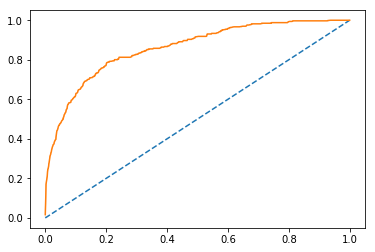

In [44]:
ax=sns.lineplot([0,1],[0,1])
ax.lines[0].set_linestyle('--')
sns.lineplot(fpr,tpr)
plt.show()

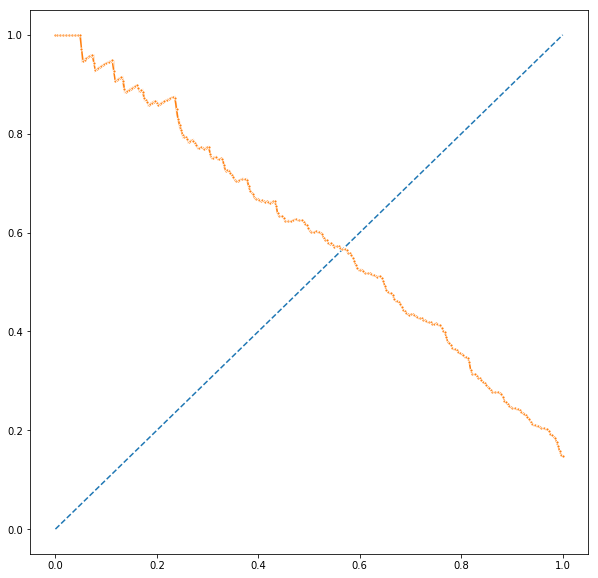

(2111,)


In [67]:
precision , recall , ths = precision_recall_curve(y_test,y_pred)
plt.figure(figsize=(10,10))
ax=sns.lineplot([0,1],[0,1])
ax.lines[0].set_linestyle('--')
sns.lineplot(recall,precision,marker='.')
plt.show()


In [53]:
y_pred=estim.predict(test_dataset)
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2022
           1       0.72      0.36      0.48       331

   micro avg       0.89      0.89      0.89      2353
   macro avg       0.81      0.67      0.71      2353
weighted avg       0.88      0.89      0.87      2353



[Text(0, 0, 'gender_of_respondent'),
 Text(0, 0, 'year'),
 Text(0, 0, 'location_type'),
 Text(0, 0, 'relationship_with_head'),
 Text(0, 0, 'job_type'),
 Text(0, 0, 'country'),
 Text(0, 0, 'age_of_respondent'),
 Text(0, 0, 'cellphone_access'),
 Text(0, 0, 'education_level')]

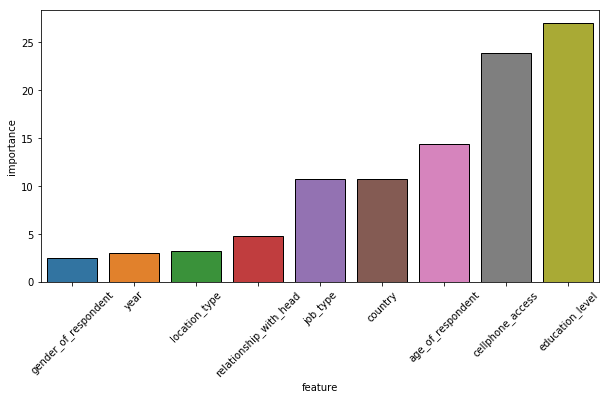

In [36]:
df1=pd.DataFrame({"feature":x_train.columns,
              "importance": estim.get_feature_importance(Pool(X, label=y, cat_features=cat_features))
             }).sort_values(by="importance")

plt.figure(figsize=(10,5))
ax=sns.barplot(data=df1,x="feature",y="importance")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


# submission

In [54]:
def submit(model, name="MySubmission.csv"):
  prediction=model.predict(X_test.values)
  test["bank_account"]=np.round(prediction[:])
  submission=pd.DataFrame({ 
    "uniqueid": test["uniqueid"]+" x "+test["country"],
    "bank_account" : test["bank_account"] })
  submission.head() 
  with open(name,"w") as f:
    f.write(submission.to_csv(index=False))    

In [71]:
submit(estim)

with submitting I got an error of 0.109 

